In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rakhe\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rakhe\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rakhe\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rakhe\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [6]:
# Load your data
# Assuming your data is in a CSV file with 'sentiment' and 'content' columns
df = pd.read_csv('sentiment_data.csv')

# Display first few rows and basic information
df.head(5)

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  40000 non-null  object
 1   content    40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB
None


In [8]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [9]:
# Text preprocessing functions
def preprocess_text(text):
    """Clean and preprocess text data"""
    # Initialize lemmatizer and stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
             if token not in stop_words and len(token) > 2]
    
    return ' '.join(tokens)

# Apply preprocessing to the content column
print("Preprocessing texts...")
df['processed_content'] = df['content'].apply(preprocess_text)

# Display some processed examples
print("\nProcessed text examples:")
for i in range(3):
    print(f"\nOriginal: {df['content'].iloc[i]}")
    print(f"Processed: {df['processed_content'].iloc[i]}")

Preprocessing texts...

Processed text examples:

Original: @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[
Processed: know listenin bad habit earlier started freakin part

Original: Layin n bed with a headache  ughhhh...waitin on your call...
Processed: layin bed headache ughhhhwaitin call

Original: Funeral ceremony...gloomy friday...
Processed: funeral ceremonygloomy friday


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_content'], 
    df['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

# Check class distribution
print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting set class distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 32000
Testing set size: 8000

Training set class distribution:
sentiment
neutral       0.215938
worry         0.211469
happiness     0.130219
sadness       0.129125
love          0.096062
surprise      0.054688
fun           0.044406
relief        0.038156
hate          0.033063
empty         0.020688
enthusiasm    0.018969
boredom       0.004469
anger         0.002750
Name: proportion, dtype: float64

Testing set class distribution:
sentiment
neutral       0.216000
worry         0.211500
happiness     0.130250
sadness       0.129125
love          0.096000
surprise      0.054625
fun           0.044375
relief        0.038125
hate          0.033125
empty         0.020625
enthusiasm    0.019000
boredom       0.004500
anger         0.002750
Name: proportion, dtype: float64


In [11]:
# Create and train the pipeline with GridSearchCV
# This cell might take some time to execute
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=5
    )),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

# Define parameters for grid search
param_grid = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}

# Create and train GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("Training model...")
grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)

Training model...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'clf__max_depth': None, 'clf__n_estimators': 200, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}


Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       152
         fun       0.07      0.01      0.02       355
   happiness       0.30      0.35      0.33      1042
        hate       0.38      0.18      0.24       265
        love       0.47      0.42      0.44       768
     neutral       0.34      0.51      0.41      1728
      relief       0.16      0.03      0.05       305
     sadness       0.33      0.22      0.27      1033
    surprise       0.17      0.04      0.06       437
       worry       0.34      0.49      0.40      1692

    accuracy                           0.34      8000
   macro avg       0.20      0.17      0.17      8000
weighted avg       0.30      0.34      0.31      8000



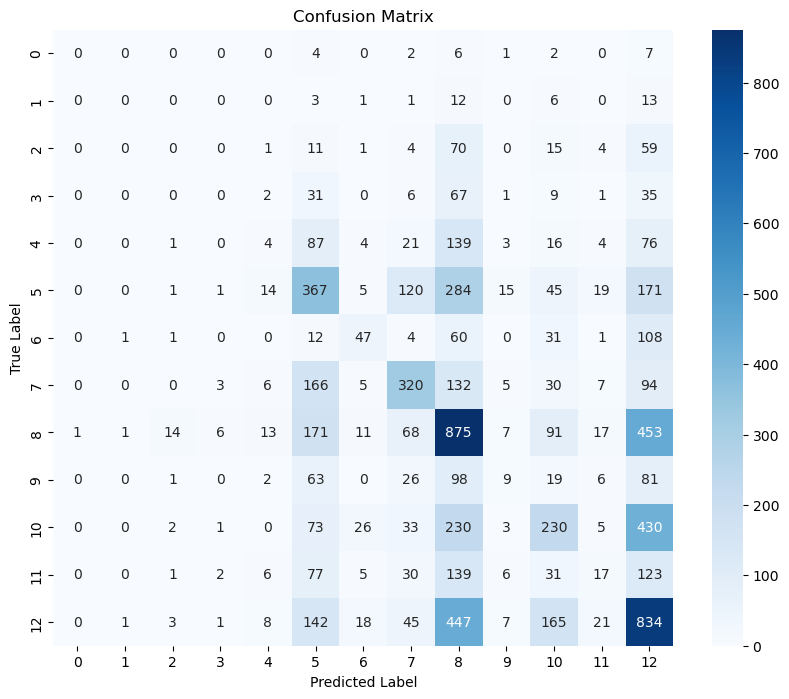

In [12]:
# Make predictions and evaluate the model
y_pred = grid_search.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            fmt='d', 
            cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
# Function to predict sentiment for new texts
def predict_sentiment(text, model=grid_search):
    # Preprocess the text
    processed_text = preprocess_text(text)
    # Make prediction
    prediction = model.predict([processed_text])[0]
    return prediction

# Test the model with some example texts
example_texts = [
    "I love this product! It's amazing!",
    "This is the worst experience ever.",
    "The weather is okay today, nothing special.",
    "@friend I'm so excited to see you tomorrow!"
]

print("Example predictions:")
for text in example_texts:
    sentiment = predict_sentiment(text)
    print(f"\nText: {text}")
    print(f"Predicted sentiment: {sentiment}")

Example predictions:

Text: I love this product! It's amazing!
Predicted sentiment: love

Text: This is the worst experience ever.
Predicted sentiment: worry

Text: The weather is okay today, nothing special.
Predicted sentiment: neutral

Text: @friend I'm so excited to see you tomorrow!
Predicted sentiment: happiness


In [14]:
# Export the trained model to pickle file
import pickle

# Save the entire model pipeline
model_filename = 'sentiment_analysis_model.pkl'
print(f"Saving model to {model_filename}...")
pickle.dump(grid_search, open(model_filename, 'wb'))
print("Model saved successfully!")

Saving model to sentiment_analysis_model.pkl...
Model saved successfully!


In [15]:
# Function to load the model and make predictions
def load_model_and_predict(text, model_path='sentiment_analysis_model.pkl'):
    # Load the model
    loaded_model = pickle.load(open(model_path, 'rb'))
    
    # Preprocess the text (using our previous preprocess_text function)
    processed_text = preprocess_text(text)
    
    # Make prediction
    prediction = loaded_model.predict([processed_text])[0]
    
    return prediction

# Test the loaded model
test_text = "I'm really happy today!"
prediction = load_model_and_predict(test_text)
print(f"\nTest text: {test_text}")
print(f"Predicted sentiment: {prediction}")


Test text: I'm really happy today!
Predicted sentiment: happiness
